## **Fluidos en Cuda**


Para pasar las cosas a CUDA es necesario ver en el algoritmo las partes que necesitan repetirse vairas veces, ya que estas las vamos a correr en la gráfica. En nuestro tenemos lo siguiente

![image.png](attachment:image.png)

En base a lo anterior se va estructurar el codigo de LBWaves.

1. In the execution menu choice the GPU acceleration option

2. The next lines verify if a GPU was assigned

In [ ]:
# Show if a CUDA Toolkit was installed
!ls /usr/local

bin    cuda	cuda-12.2  games	       include	lib64	   man	 share
colab  cuda-12	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [16]:
# Show it the  nvcc command can be called
!which nvcc

/usr/local/cuda/bin/nvcc


In [17]:
# Show which NVIDIA card was assigned
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

In [18]:
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul 12 15:46:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

3. Just paste your code below the line
%%writefile RunCode.cu

In [21]:
%%writefile LBM_Fluid2D_D2Q9_CUDA.cu
// LB for Fluids D2Q9 on CUDA
#include <iostream>
#include <fstream>
#include <cmath>
using namespace std;

#define Lx 256
#define Ly 64
#define N 32 // Threads per Block
const int M=(Lx*Ly+N-1)/N; // Blocks per Grid
#define Q 9
const int ArraySize=Lx*Ly*Q;

const float tau=0.55;
const float Utau=1.0/tau;
const float UmUtau=1-Utau;

//------------ PROGRAMMING ON THE DEVICE ----------------
//---------------Constants (Symbols)----------------
__constant__ float d_w[9];
__constant__ int d_Vx[9];
__constant__ int d_Vy[9];
__constant__ float d_tau[3]; // d_tau[0]=tau,  d_tau[1]=Utau,  d_tau[2]=UmUtau,

//----------Functions called by the device itself
__device__ int d_n(int ix, int iy, int i) {
    return ix * Ly * Q + iy * Q + i;
}

__device__ float d_rho(int ix, int iy, float *d_f) {
    float sum = 0; int i, n0;
    for (i = 0; i < Q; i++) {
        n0 = d_n(ix, iy, i); sum += d_f[n0];
    }
    return sum;
}

__device__ float d_Jx(int ix, int iy, float *d_f) {
    float sum = 0; int i, n0;
    for (i = 0; i < Q; i++) {
        n0 = d_n(ix, iy, i); sum += d_Vx[i] * d_f[n0];
    }
    return sum;
}

__device__ float d_Jy(int ix, int iy, float *d_f) {
    float sum = 0; int i, n0;
    for (i = 0; i < Q; i++) {
        n0 = d_n(ix, iy, i); sum += d_Vy[i] * d_f[n0];
    }
    return sum;
}

__device__ float d_feq(float rho0, float Ux0, float Uy0, int i) {
    float UdotVi = Ux0 * d_Vx[i] + Uy0 * d_Vy[i], U2 = Ux0 * Ux0 + Uy0 * Uy0;
    return rho0 * d_w[i] * (1 + 3 * UdotVi + 4.5 * UdotVi * UdotVi - 1.5 * U2);
}

//---------------------KERNELS----------------------------
__global__ void d_Collision(float *d_f, float *d_fnew) {
    int icell, ix, iy, i, n0; float rho0, Ux0, Uy0;
    icell = blockIdx.x * blockDim.x + threadIdx.x;
    ix = icell / Ly; iy = icell % Ly;
    if (icell < Lx * Ly) {
        rho0 = d_rho(ix, iy, d_f);
        Ux0 = d_Jx(ix, iy, d_f) / rho0;
        Uy0 = d_Jy(ix, iy, d_f) / rho0;
        for (i = 0; i < Q; i++) {
            n0 = d_n(ix, iy, i);
            d_fnew[n0] = d_tau[2] * d_f[n0] + d_tau[1] * d_feq(rho0, Ux0, Uy0, i);
        }
    }
}

__global__ void d_ImposeFields(float *d_f, float *d_fnew, float Ufan) {
    int ix, iy, i, n0, ixc = Lx / 8, iyc = Ly / 2, R = Ly / 5; float rho0;
    int icell = blockIdx.x * blockDim.x + threadIdx.x;
    ix = icell / Ly; iy = icell % Ly;
    float R2 = R * R;
    if (icell < Lx * Ly) {
        rho0 = d_rho(ix, iy, d_f);
        if (ix == 0) {
            for (i = 0; i < Q; i++) { n0 = d_n(ix, iy, i); d_fnew[n0] = d_feq(rho0, Ufan, 0, i); }
        } else if ((ix - ixc) * (ix - ixc) + (iy - iyc) * (iy - iyc) <= R2) {
            for (i = 0; i < Q; i++) { n0 = d_n(ix, iy, i); d_fnew[n0] = d_feq(rho0, 0, 0, i); }
        } else if (ix == ixc && iy == iyc + R + 1) {
            for (i = 0; i < Q; i++) { n0 = d_n(ix, iy, i); d_fnew[n0] = d_feq(rho0, 0, 0, i); }
        }
    }
}

__global__ void d_Advection(float *d_f, float *d_fnew) {
    int icell, ix, iy, i, ixnext, iynext, n0, n0next;
    icell = blockIdx.x * blockDim.x + threadIdx.x;
    ix = icell / Ly; iy = icell % Ly;
    if (icell < Lx * Ly) {
        for (i = 0; i < Q; i++) {
            ixnext = (ix + d_Vx[i] + Lx) % Lx;
            iynext = (iy + d_Vy[i] + Ly) % Ly;
            n0 = d_n(ix, iy, i); n0next = d_n(ixnext, iynext, i);
            d_f[n0next] = d_fnew[n0];
        }
    }
}

//------------ PROGRAMMING ON THE HOST ----------------
//-------------LatticeBoltzmann class------------

class LatticeBoltzmann {
private:
    float h_tau[3];
    float h_w[9];
    int h_Vx[9], h_Vy[9];
    float *h_f, *h_fnew;  float *d_f, *d_fnew;
public:
    LatticeBoltzmann(void);
    ~LatticeBoltzmann(void);
    int h_n(int ix, int iy, int i) { return (ix * Ly + iy) * Q + i; }
    float h_rho(int ix, int iy);
    float h_Jx(int ix, int iy);
    float h_Jy(int ix, int iy);
    float h_feq(float rho0, float Ux0, float Uy0, int i);
    void Start(float rho0, float Ux0, float Uy0);
    void Collision(void);
    void ImposeFields(float Ufan);
    void Advection(void);
    void Print(const char * NameFile, float Ufan);
};

LatticeBoltzmann::LatticeBoltzmann(void) {

    // Inicialización de las constantes en el host
    h_tau[0] = tau;  h_tau[1] = Utau;  h_tau[2] = UmUtau;
    h_w[0] = 4.0 / 9; h_w[1] = h_w[2] = h_w[3] = h_w[4] = 1.0 / 9;
    h_w[5] = h_w[6] = h_w[7] = h_w[8] = 1.0 / 36;
    h_Vx[0] = 0;  h_Vx[1] = 1;  h_Vx[2] = 0;  h_Vx[3] = -1; h_Vx[4] = 0;
    h_Vx[5] = 1;  h_Vx[6] = -1; h_Vx[7] = -1; h_Vx[8] = 1;
    h_Vy[0] = 0;  h_Vy[1] = 0;  h_Vy[2] = 1;  h_Vy[3] = 0;  h_Vy[4] = -1;
    h_Vy[5] = 1;  h_Vy[6] = 1;  h_Vy[7] = -1; h_Vy[8] = -1;

    // Copia de constantes a la memoria de la GPU
    cudaMemcpyToSymbol(d_w, h_w, Q * sizeof(float), 0, cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_Vx, h_Vx, Q * sizeof(int), 0, cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_Vy, h_Vy, Q * sizeof(int), 0, cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_tau, h_tau, 3 * sizeof(float), 0, cudaMemcpyHostToDevice);

// Asignación de memoria para las funciones de distribución en el host
    h_f = new float[ArraySize];  h_fnew = new float[ArraySize];

    // Asignación de memoria para las funciones de distribución en la GPU
    cudaMalloc((void**)&d_f, ArraySize * sizeof(float));
    cudaMalloc((void**)&d_fnew, ArraySize * sizeof(float));
}
//---------------------Destructor---------------------
LatticeBoltzmann::~LatticeBoltzmann(void){
    delete[] h_f;  delete[] h_fnew;
    cudaFree(d_f);  cudaFree(d_fnew);
}

//---------------------Start---------------------
// Inicializa las funciones de distribución en el host
void LatticeBoltzmann::Start(float rho0, float Ux0, float Uy0) {
    int ix, iy, i, n0;
    for (ix = 0; ix < Lx; ix++) {
        for (iy = 0; iy < Ly; iy++) {
            for (i = 0; i < Q; i++) {
                n0 = h_n(ix, iy, i);
                h_f[n0] = h_feq(rho0, Ux0, Uy0, i);
            }
        }
    }

    // Copia las funciones de distribución inicializadas a la GPU
    cudaMemcpy(d_f, h_f, ArraySize * sizeof(float), cudaMemcpyHostToDevice);
}
//---------------------Campos macroscópicos---------------------
float LatticeBoltzmann::h_rho(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_fnew[n0];
  }
  return sum;
}
float LatticeBoltzmann::h_Jx(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_Vx[i]*h_fnew[n0];
  }
  return sum;
}
float LatticeBoltzmann::h_Jy(int ix,int iy){
  //Note: Please import data from device before running
  float sum; int i,n0;
  for(sum=0,i=0;i<Q;i++){
    n0=h_n(ix,iy,i); sum+=h_Vy[i]*h_fnew[n0];
  }
  return sum;
}

//---------------------Función de equilibrio---------------------
float LatticeBoltzmann::h_feq(float rho0, float Ux0, float Uy0, int i) {
    float UdotVi = Ux0 * h_Vx[i] + Uy0 * h_Vy[i], U2 = Ux0 * Ux0 + Uy0 * Uy0;
    return rho0 * h_w[i] * (1 + 3 * UdotVi + 4.5 * UdotVi * UdotVi - 1.5 * U2);
}

//---------------------Reglas de evolución---------------------

void LatticeBoltzmann::Collision(void) {
    dim3 ThreadsPerBlock(N, 1, 1);
    dim3 BlocksPerGrid(M, 1, 1);
    d_Collision<<<BlocksPerGrid, ThreadsPerBlock>>>(d_f, d_fnew);
}

void LatticeBoltzmann::ImposeFields(float Ufan) {
    dim3 ThreadsPerBlock(N, 1, 1);
    dim3 BlocksPerGrid(M, 1, 1);
    d_ImposeFields<<<BlocksPerGrid, ThreadsPerBlock>>>(d_f, d_fnew, Ufan);
}

void LatticeBoltzmann::Advection(void) {
    dim3 ThreadsPerBlock(N, 1, 1);
    dim3 BlocksPerGrid(M, 1, 1);
    d_Advection<<<BlocksPerGrid, ThreadsPerBlock>>>(d_f, d_fnew);
}

void LatticeBoltzmann::Print(const char * NameFile, float Ufan) {

    ofstream MyFile(NameFile);
    double rho0, Ux0, Uy0;
    int ix, iy;

    cudaMemcpy(h_fnew, d_fnew, ArraySize * sizeof(float), cudaMemcpyDeviceToHost);

    for (ix = 0; ix < Lx; ix += 4) {
        for (iy = 0; iy < Ly; iy += 4) {
            //rho0 = h_rho(ix, iy); Ux0 = h_Jx(ix, iy, true) / rho0; Uy0 = h_Jy(ix, iy, true) / rho0;
            rho0 = h_rho(ix, iy); Ux0 = h_Jx(ix, iy) / rho0; Uy0 = h_Jy(ix, iy) / rho0;
            MyFile << ix << " " << iy << " " << Ux0 / Ufan * 4 << " " << Uy0 / Ufan * 4 << endl;
        }
        MyFile << endl;
    }
    MyFile.close();
}

//--------------- GLOBAL FUNCTIONS ------------
int main(void) {
    LatticeBoltzmann Air;
    int t, tmax = 10000;
    float rho0 = 1.0, Ufan0 = 0.1;

    Air.Start(rho0, Ufan0, 0);
    for (t = 0; t < tmax; t++) {
        Air.Collision();
        Air.ImposeFields(Ufan0);
        Air.Advection();
    }
    Air.Print("WindChannel.dat", Ufan0);

    return 0;
}


Overwriting LBM_Fluid2D_D2Q9_CUDA.cu


In [22]:
%%shell
time nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 LBM_Fluid2D_D2Q9_CUDA.cu -o Ejecutar
./Ejecutar


real	0m3.687s
user	0m2.365s
sys	0m0.471s


In [23]:

import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos
datos = np.loadtxt("WindChannel.dat")
X, Y, Ux, Uy = datos[:, 0], datos[:, 1], datos[:, 2], datos[:, 3]
X, Y , Ux, Uy

(array([  0.,   0.,   0., ..., 252., 252., 252.]),
 array([ 0.,  4.,  8., ..., 52., 56., 60.]),
 array([4.     , 4.     , 4.     , ..., 3.79329, 3.79005, 3.80469]),
 array([ 0.00000e+00,  0.00000e+00,  1.47716e-07, ..., -3.16193e+00,
        -3.27224e+00, -3.38169e+00]))

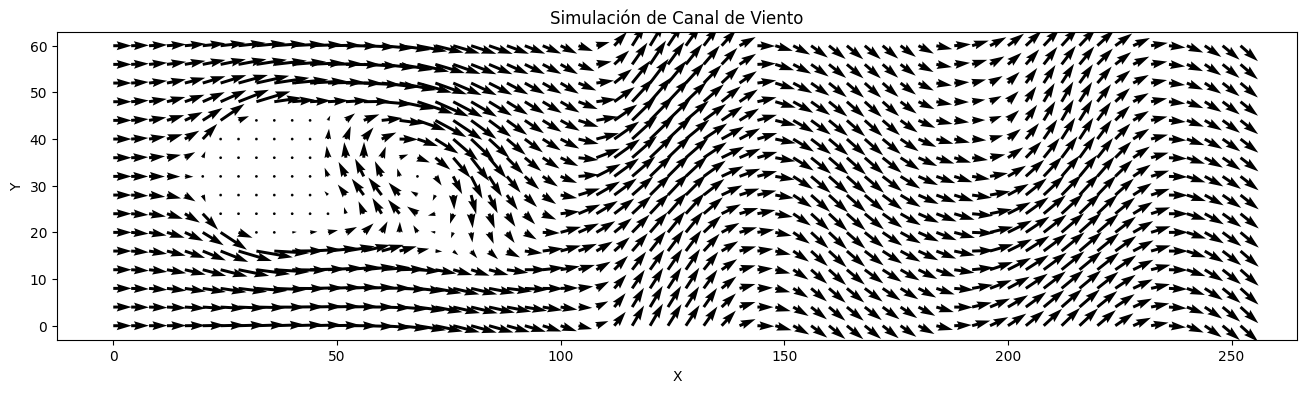

In [24]:
# Configurar el tamaño de la figura
plt.figure(figsize=(16, 4))  # Aumentar la longitud de la imagen

# Crear el gráfico de vectores
plt.quiver(X, Y, Ux, Uy)

# Configurar las etiquetas y el título
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulación de Canal de Viento')

# Mostrar el gráfico
plt.show()
